# CMSC320 Final Project: Predicting future rent prices in the DMV (D.C., Maryland, and Virginia) Metropolitan Area

## Spring 2025 Data Science Project ###

## Jay Sampat and Aadi Anand ###

Contributions:

*Both team memebers contributed to all parts of the project. The names listed below simply show who was "responsible" for which part of the project.*

A: Project idea
- Both team members. We both discussed and came up with a project idea that was interesting and important to us. 

B: Dataset Curation and Preprocessing
- Aadi worked on finding and creating the data set and preprocessing the data so it was ready to use. 

C: Data Exploration and Summary Statistics
- Aadi worked on data exploration, the statistical methods, creating the plots, and drawing conclusions for each method. 

D: ML Algorithm Design/Development
- Jay worked on the ML algorithm, choosing the technique, designing the model and testing its effectiveness. 

E: ML Algorithm Training and Test Data Analysis
- Jay worked on training the model and analysis of the traning and test data. 

F: Visualization, Result Analysis, Conclusion
- Aadi worked on analysing the results, visualizing our findings, and writing the conclusion of our findings.

G: Final Tutorial Report Creation
- Both team members contributed to the final creation of the tutorial. 

### Introduction ###

Our goal for this project is to predict the rent prices of apartments in the DMV (Washington D.C.)
area since we are very close and may live near Washington D.C. in the future. We want to
understand how the features and aspects of apartments in the DMV affect rent prices (e.g.,
location, year, number of bedrooms). We want to use what we learn about visualizing data and
machine learning in this course to accurately understand the factors that affect rent and predict
rent prices with given features as inputs. We will create a prediction model to input the year,
county, and size of the apartment to accurately predict the cost of the apartment in that year.
Using the datasets from this government website allows us to use the past 8 years of data to
train our model, and we will do initial data analysis to have the most accurate prediction.

### Imports

In [1]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor



### Data Curation

In [2]:
# Load the datasets for 2019 - 2025 (excluding 2020). 
# Datasets consist of Fair Market Rent (FMR) data for the Washington-Arlington-Alexandria, DC-VA-MD HUD Metro FMR Area.

dfs = {}

for i in range(2019, 2026):
    if i == 2020:
        continue
    
    df = pd.read_excel(f'datasets/fmrs_{i}.xlsx')
    df = df[df['HUD Metro Fair Market Rent Area Name'] == 'Washington-Arlington-Alexandria, DC-VA-MD HUD Metro FMR Area']
    df = df.drop(df.columns[[1, 2, 4, 5, 7, 8, 10, 11, 13, 14, 16, 17] if i < 2022 else [0, 1]], axis=1)
    df = df.reset_index(drop=True)
    
    df = df.rename(columns={
            'ZIP\nCode': 'zip_code',
            'SAFMR\n0BR': '0_bedroom',
            'SAFMR\n1BR': '1_bedroom',
            'SAFMR\n2BR': '2_bedroom',
            'SAFMR\n3BR': '3_bedroom',
            'SAFMR\n4BR': '4_bedroom'
        } if i < 2022 else {
            'ZIP\nCode': 'zip_code',
            'erap_fmr_br0': '0_bedroom',
            'erap_fmr_br1': '1_bedroom',
            'erap_fmr_br2': '2_bedroom',
            'erap_fmr_br3': '3_bedroom',
            'erap_fmr_br4': '4_bedroom'
        })
    
    df = df[df['zip_code'] != 88888]
    
    dfs[i] = df

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [3]:
# Load dataset for 2020
df_2020 = pd.read_excel('data/fy2020_safmrs_rev.xlsx')
df_2020 = df_2020[df_2020['Areaname20'] == 'Washington-Arlington-Alexandria, DC-VA-MD HUD Metro FMR Area']
df_2020 = df_2020.rename(columns={
        'zcta' : 'zip_code',
        'safmr_0br': '0_bedroom',
        'safmr_1br': '1_bedroom',
        'safmr_2br': '2_bedroom',
        'safmr_3br': '3_bedroom',
        'safmr_4br': '4_bedroom'
    })
df_2020 = df_2020.drop(['CBSASub20', 'Areaname20', 'safmr_0br_90pct_pay_std', 'safmr_0br_110pct_pay_std','safmr_1br_90pct_pay_std',  'safmr_1br_110pct_pay_std', 'safmr_2br_90pct_pay_std',  'safmr_2br_110pct_pay_std', 'safmr_3br_90pct_pay_std', 'safmr_3br_110pct_pay_std', 'safmr_4br_90pct_pay_std', 'safmr_4br_110pct_pay_std'], axis=1)
df_2020 = df_2020[df_2020['zip_code'] != 88888]
df_2020 = df_2020.reset_index(drop = True)

dfs[2020] = df_2020


In [4]:
zip_codes = pd.read_csv('data/zip_code_database.csv')
zip_codes = zip_codes[zip_codes['state'].isin(['MD', 'VA', 'DC'])]
display(zip_codes)

,zip,type,decommissioned,primary_city,acceptable_cities,unacceptable_cities,state,county,timezone,area_codes,world_region,country,latitude,longitude,irs_estimated_population
8278,20001,STANDARD,0,Washington,NaN,NaN,DC,District of Columbia,America/New_York,"202, 771",NaN,US,38.91,-77.02,33910
8279,20002,STANDARD,0,Washington,NaN,NaN,DC,District of Columbia,America/New_York,"202, 771",NaN,US,38.91,-76.98,53730
8280,20003,STANDARD,0,Washington,NaN,NaN,DC,District of Columbia,America/New_York,"202, 771",NaN,US,38.88,-76.99,29800
8281,20004,STANDARD,0,Washington,NaN,NaN,DC,District of Columbia,America/New_York,"202, 771",NaN,US,38.90,-77.03,1170
8282,20005,STANDARD,0,Washington,NaN,NaN,DC,District of Columbia,America/New_York,"202, 771",NaN,US,38.90,-77.03,8310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25201,56984,UNIQUE,0,Parcel Return Service,Prs,Parcel Return Svc,DC,NaN,America/New_York,NaN,NaN,US,0.00,0.00,0
25202,56985,UNIQUE,0,Parcel Return Service,Prs,Parcel Return Svc,DC,NaN,America/New_York,NaN,NaN,US,0.00,0.00,0
25203,56998,UNIQUE,0,Parcel Return Service,Prs,Parcel Return Svc,DC,NaN,America/New_York,"202, 771",NaN,US,38.89,-77.03,0
25204,56999,UNIQUE,0,Parcel Return Service,Prs,Parcel Return Svc,DC,NaN,America/New_York,"202, 771",NaN,US,38.89,-77.03,0


In [5]:
# Load dataset for 2018
df_2018 = pd.read_excel('data/FY18_4050_FMRs_rev.xlsx')
df_2018 = df_2018[df_2018['areaname'] == 'Washington-Arlington-Alexandria, DC-VA-MD HUD Metro FMR Area']

zip_codes['county'] = zip_codes['county'].str.strip().str.lower()
df_2018['countyname'] = df_2018['countyname'].str.strip().str.lower()

df_2018 = zip_codes[
    zip_codes['county'].notna() & zip_codes['county'].isin(df_2018['countyname'])
].merge(
    df_2018[['countyname', 'fmr_0', 'fmr_1', 'fmr_2', 'fmr_3', 'fmr_4']],
    left_on='county',
    right_on='countyname',
    how='left'
)[['zip', 'fmr_0', 'fmr_1', 'fmr_2', 'fmr_3', 'fmr_4']]
df_2018 = df_2018.rename(columns={
        'zip' : 'zip_code',
        'fmr_0': '0_bedroom',
        'fmr_1': '1_bedroom',
        'fmr_2': '2_bedroom',
        'fmr_3': '3_bedroom',
        'fmr_4': '4_bedroom'
    })

dfs[2018] = df_2018

In [6]:
# Load dataset for 2017

df_2017 = pd.read_excel('data/FY2017-4050-County-Level_Data.xlsx')
df_2017 = df_2017[df_2017['areaname'] == 'Washington-Arlington-Alexandria, DC-VA-MD HUD Metro FMR Area']

zip_codes['county'] = zip_codes['county'].str.strip().str.lower()
df_2017['countyname'] = df_2017['countyname'].str.strip().str.lower()

df_2017 = zip_codes[
    zip_codes['county'].notna() & zip_codes['county'].isin(df_2017['countyname'])
].merge(
    df_2017[['countyname', 'fmr0', 'fmr1', 'fmr2', 'fmr3', 'fmr4']],
    left_on='county',
    right_on='countyname',
    how='left'
)[['zip', 'fmr0', 'fmr1', 'fmr2', 'fmr3', 'fmr4']]
df_2017 = df_2017.rename(columns={
        'zip' : 'zip_code',
        'fmr0': '0_bedroom',
        'fmr1': '1_bedroom',
        'fmr2': '2_bedroom',
        'fmr3': '3_bedroom',
        'fmr4': '4_bedroom'
    })
dfs[2017] = df_2017

In [7]:
# Used 2020 as reference since it was the most recent year with 443 zip codes. 
df_2020 = dfs[2020]
for df in dfs:
    df_curr = dfs[df]
    df_curr = df_curr[df_curr['zip_code'].isin(df_2020['zip_code'])]
    dfs[df] = df_curr
    print(df)
    display(dfs[df])

2019


,zip_code,0_bedroom,1_bedroom,2_bedroom,3_bedroom,4_bedroom
0,20001,1740,1790,2050,2680,3300
1,20002,1220,1260,1440,1880,2320
2,20003,2120,2180,2500,3270,4020
3,20004,2120,2180,2500,3270,4020
4,20005,2000,2050,2350,3070,3780
...,...,...,...,...,...,...
438,22742,1170,1230,1420,1870,2320
439,22960,1170,1230,1420,1870,2320
440,23015,1170,1230,1420,1870,2320
441,23024,1170,1230,1420,1870,2320


2021


,zip_code,0_bedroom,1_bedroom,2_bedroom,3_bedroom,4_bedroom
0,20001,2080,2130,2430,3120,3780
1,20002,1330,1360,1550,1990,2410
2,20003,2270,2320,2650,3400,4120
3,20004,2270,2320,2650,3400,4120
4,20005,2160,2210,2520,3230,3910
...,...,...,...,...,...,...
500,22742,1130,1160,1320,1690,2050
501,22960,960,1000,1160,1530,1890
502,23015,960,1000,1160,1530,1890
503,23024,960,1000,1160,1530,1890


2022


,zip_code,0_bedroom,1_bedroom,2_bedroom,3_bedroom,4_bedroom
0,20001,2180,2220,2530,3200,3840
1,20002,1539,1567,1785,2260,2713
2,20003,2310,2350,2680,3390,4070
3,20004,2310,2350,2680,3390,4070
4,20005,2210,2250,2560,3240,3890
...,...,...,...,...,...,...
500,22742,1539,1567,1785,2260,2713
501,22960,1539,1567,1785,2260,2713
502,23015,1539,1567,1785,2260,2713
503,23024,1539,1567,1785,2260,2713


2023


,zip_code,0_bedroom,1_bedroom,2_bedroom,3_bedroom,4_bedroom
0,20001,2300,2340,2660,3330,3970
1,20002,1589,1615,1838,2299,2742
2,20003,2390,2430,2760,3450,4120
3,20004,2390,2430,2760,3450,4120
4,20005,2200,2240,2550,3190,3800
...,...,...,...,...,...,...
499,22742,1589,1615,1838,2299,2742
500,22960,1589,1615,1838,2299,2742
501,23015,1589,1615,1838,2299,2742
502,23024,1589,1615,1838,2299,2742


2024


,zip_code,0_bedroom,1_bedroom,2_bedroom,3_bedroom,4_bedroom
0,20001,2460,2500,2840,3530,4190
1,20002,1772,1803,2045,2544,3015
2,20003,2660,2710,3070,3820,4530
3,20004,2610,2650,3010,3740,4440
4,20005,2330,2370,2690,3350,3970
...,...,...,...,...,...,...
500,22742,1772,1803,2045,2544,3015
501,22960,1772,1803,2045,2544,3015
502,23015,1772,1803,2045,2544,3015
503,23024,1772,1803,2045,2544,3015


2025


,zip_code,0_bedroom,1_bedroom,2_bedroom,3_bedroom,4_bedroom
0,20001,2770,2830,3190,3990,4700
1,20002,2050,2100,2360,2950,3480
2,20003,3020,3080,3470,4340,5120
3,20004,2900,2960,3330,4160,4910
4,20005,2520,2580,2900,3630,4280
...,...,...,...,...,...,...
500,22742,2012,2056,2314,2893,3413
501,22960,2012,2056,2314,2893,3413
502,23015,2012,2056,2314,2893,3413
503,23024,2012,2056,2314,2893,3413


2020


,zip_code,0_bedroom,1_bedroom,2_bedroom,3_bedroom,4_bedroom
0,20001,1890,1950,2220,2880,3520
1,20002,1280,1320,1500,1950,2380
2,20003,2190,2250,2560,3320,4060
3,20004,2190,2250,2560,3320,4060
4,20005,2070,2130,2430,3150,3850
...,...,...,...,...,...,...
438,22742,1060,1110,1280,1690,2090
439,22960,1060,1110,1280,1690,2090
440,23015,1060,1110,1280,1690,2090
441,23024,1060,1110,1280,1690,2090


2018


,zip_code,0_bedroom,1_bedroom,2_bedroom,3_bedroom,4_bedroom
0,20001,1504,1561,1793,2353,2902
1,20002,1504,1561,1793,2353,2902
2,20003,1504,1561,1793,2353,2902
3,20004,1504,1561,1793,2353,2902
4,20005,1504,1561,1793,2353,2902
...,...,...,...,...,...,...
736,22712,1504,1561,1793,2353,2902
737,22720,1504,1561,1793,2353,2902
738,22728,1504,1561,1793,2353,2902
739,22734,1504,1561,1793,2353,2902


2017


,zip_code,0_bedroom,1_bedroom,2_bedroom,3_bedroom,4_bedroom
0,20001,1440,1513,1746,2300,2855
1,20002,1440,1513,1746,2300,2855
2,20003,1440,1513,1746,2300,2855
3,20004,1440,1513,1746,2300,2855
4,20005,1440,1513,1746,2300,2855
...,...,...,...,...,...,...
736,22712,1440,1513,1746,2300,2855
737,22720,1440,1513,1746,2300,2855
738,22728,1440,1513,1746,2300,2855
739,22734,1440,1513,1746,2300,2855


### Exploratory Data Analysis

#### Default assumptions
1. $\alpha$ (critical value) = 0.05

#### Hypothesis test #1

$H_0:$ There is no difference in average one bedroom rent prices for all the years

$H_a:$ There is a difference in average one bedroom rent prices for at least one of the years

0.0


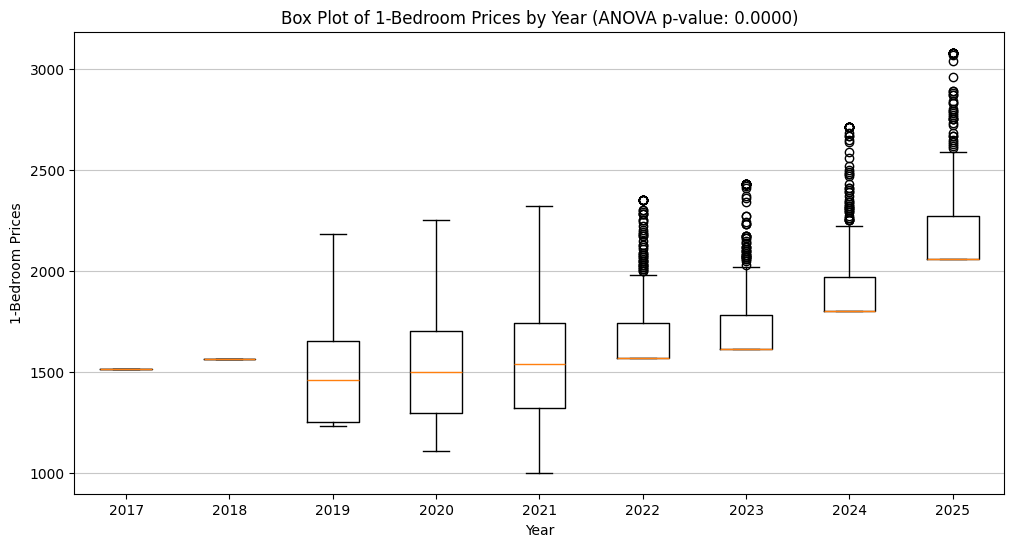

In [8]:
# Test: ANOVA

samples = []

for year in range(2017, 2026):
    df = dfs[year]
    samples.append(df['1_bedroom'])


res = stats.f_oneway(*samples)
pvalue = res.pvalue
print(pvalue)

plt.figure(figsize=(12, 6))
plt.boxplot(samples)
    
plt.xticks(range(1, len(samples) + 1), [f'{year}' for year in range(2017, 2026)])
plt.xlabel('Year')
plt.ylabel('1-Bedroom Prices')
plt.title('Box Plot of 1-Bedroom Prices by Year (ANOVA p-value: {:.4f})'.format(pvalue))

plt.grid(axis='y', alpha=0.7)
plt.show()

Conclusion: Since the p-value (0.0) < $\alpha$ (0.05), we reject $H_0$. There is enough evidence to suggest that $H_a$ is true, meaning that at least one of the years has a different average one bedroom rent prices compared to all the other years

### Hypothesis test #2

Since from the first test we used ANOVA to conclude there is at least one different group, we can use a Post-Hoc test to find out which group is different

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)    -48.000     0.068   -97.732     1.732
 (0 - 2)      2.729     1.000   -46.381    51.839
 (0 - 3)    -20.093     0.940   -69.203    29.018
 (0 - 4)    -47.429     0.068   -96.539     1.681
 (0 - 5)   -182.928     0.000  -232.065  -133.790
 (0 - 6)   -226.717     0.000  -275.854  -177.580
 (0 - 7)   -425.226     0.000  -474.364  -376.089
 (0 - 8)   -693.204     0.000  -742.341  -644.066
 (1 - 0)     48.000     0.068    -1.732    97.732
 (1 - 2)     50.729     0.037     1.619    99.839
 (1 - 3)     27.907     0.706   -21.203    77.018
 (1 - 4)      0.571     1.000   -48.539    49.681
 (1 - 5)   -134.928     0.000  -184.065   -85.790
 (1 - 6)   -178.717     0.000  -227.854  -129.580
 (1 - 7)   -377.226     0.000  -426.364  -328.089
 (1 - 8)   -645.204     0.000  -694.341  -596.066
 (2 - 0)     -2.729     1.000   -51.839    46.381
 (2 - 1)    -50.729     0.037   

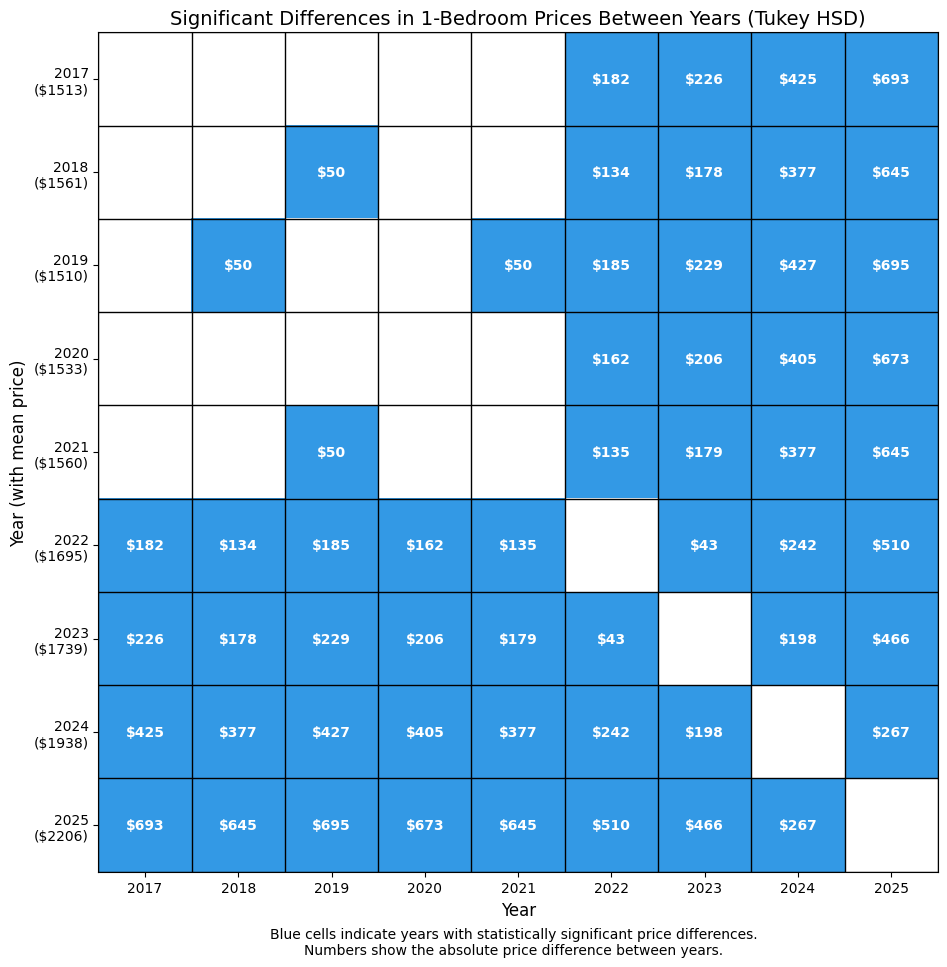

In [9]:
res = stats.tukey_hsd(*samples)

print(res)

years = list(range(2017, 2026))
n_years = len(years)
significance_matrix = np.zeros((n_years, n_years))

significant_pairs = {
    2017: [2022, 2023, 2024, 2025],
    2018: [2019, 2022, 2023, 2024, 2025],
    2019: [2018, 2021, 2022, 2023, 2024, 2025],
    2020: [2022, 2023, 2024, 2025],
    2021: [2019, 2022, 2023, 2024, 2025],
    2022: [2017, 2018, 2019, 2020, 2021, 2023, 2024, 2025],
    2023: [2017, 2018, 2019, 2020, 2021, 2022, 2024, 2025],
    2024: [2017, 2018, 2019, 2020, 2021, 2022, 2023, 2025],
    2025: [2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
}

for i, year1 in enumerate(years):
    for year2 in significant_pairs.get(year1, []):
        j = years.index(year2)
        significance_matrix[i, j] = 1

means = [np.mean(sample) for sample in samples]

fig, ax = plt.subplots(figsize=(12, 10))

colors = [(1, 1, 1), (0.2, 0.6, 0.9)]  
cmap = pltcolors.LinearSegmentedColormap.from_list('custom_cmap', colors, N=2)

im = ax.imshow(significance_matrix, cmap=cmap, vmin=0, vmax=1)

for i in range(n_years + 1):
    ax.axhline(i - 0.5, color='black', linewidth=1)
    ax.axvline(i - 0.5, color='black', linewidth=1)

ax.set_xticks(range(n_years))
ax.set_yticks(range(n_years))
ax.set_xticklabels(years)
ax.set_yticklabels([f"{year}\n(${int(mean)})" for year, mean in zip(years, means)])

for i in range(n_years):
    for j in range(n_years):
        if significance_matrix[i, j] == 1:
            diff = means[i] - means[j]
            diff_text = f"${int(abs(diff))}"
            
            ax.text(j, i, diff_text, 
                   ha="center", va="center", 
                   color="white" if significance_matrix[i, j] else "black",
                   fontweight='bold')

plt.title("Significant Differences in 1-Bedroom Prices Between Years (Tukey HSD)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Year (with mean price)", fontsize=12)

plt.figtext(0.5, 0.01, 
            "Blue cells indicate years with statistically significant price differences.\n"
            "Numbers show the absolute price difference between years.", 
            ha="center", fontsize=10)

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

Conclusion: Every year has a significant difference in average rent prices for one bedroom apartments in the DMV area compared with all other years. However, the most significant/different years seem to be 2022 - 2025, which makes sense since this was around the time inflation due to COVID-19 impacted the economy (inlcuding rent prices in major metropolitan areas like the DMV)

### Hypothesis test #3

Since 2021 was the year most affected by COVID-19, we can run a Z-test on 2021 Fair Market Rents to compare the sample mean to the population mean. We can take the Fair Market Rents of 1 bedroom since that was the most common layout rented in the DMV. 

In [10]:
df_2021 = dfs[2021]
df_2021_1_bedroom = df_2021['1_bedroom']
df_2021_1_bedroom
pop_sd = df_2021_1_bedroom.std()
sample_mean = df_2021_1_bedroom.mean()
sample_size = len(df_2021_1_bedroom)

$H_0:$ The average Fair Market Rent for a 1-bedroom unit in 2021 is $1560.
(There is no significant difference between the observed mean and $1560.)
μ = 1560

$H_a:$ The average Fair Market Rent for a 1-bedroom unit in 2021 is not $1560.
(There is a significant difference between the observed average and $1560.)
μ ≠ 1560

Z-score: 3.868784001172505
P-value: 0.0001093794835227424


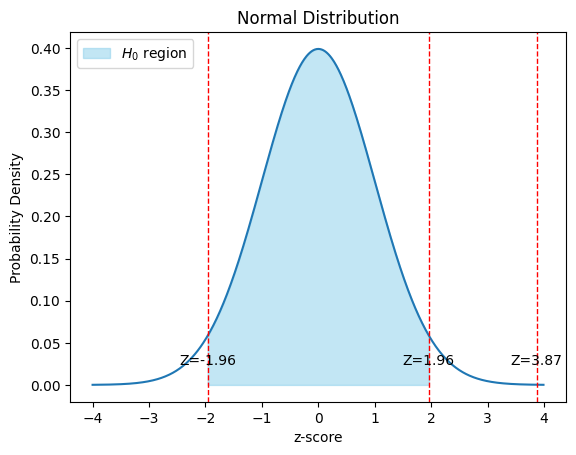

In [11]:
mu = 1500
z_score = (sample_mean - mu) / (pop_sd / np.sqrt(sample_size))
p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))
print(f"Z-score: {z_score}")
print(f"P-value: {p_value}")



ax = plt.subplots(1, 1)
x_axis = np.arange(-4, 4, 0.01)
y_axis = stats.norm.pdf(x_axis, 0, 1)

plt.plot(x_axis, y_axis)

z_marks = [-1.96, 1.96, z_score]
for z in z_marks:
    plt.axvline(x=z, color='r', linestyle='--', linewidth=1)
    plt.text(z, 0.02, f'Z={round(z, 2)}', ha='center', va='bottom')

z_fill_left = -1.96
z_fill_right = 1.96
x_fill = np.linspace(z_fill_left, z_fill_right, 100)
y_fill = stats.norm.pdf(x_fill)
plt.fill_between(x_fill, y_fill, color='skyblue', alpha=0.5, label=f'$H_0$ region')
plt.legend()

plt.title('Normal Distribution')
plt.xlabel('z-score')
plt.ylabel('Probability Density')

plt.show()


Conclusion: Since the p-value is less than $\alpha$ 0.05, we reject the null hypothesis. This suggests that the average Fair Market Rent for a 1-bedroom unit in 2021 is significantly different from $1500.

### Primary analysis ###


In [12]:
# Combining all the data into one dataframe to be used easily for testing. 
# The data frame will have a column for bedrooms, rent_price, zip code, and year.  
reshaped_rows = []

for year, df in dfs.items():
    # Melt from wide to long format
    df_long = df.melt(id_vars=["zip_code"], 
                      value_vars=["0_bedroom", "1_bedroom", "2_bedroom", "3_bedroom", "4_bedroom"],
                      var_name="bedrooms", value_name="rent_price")
    
    # Clean bedroom column (convert '1_bedroom' → 1)
    df_long["bedrooms"] = df_long["bedrooms"].str.extract(r'(\d)').astype(int)
    
    # Add year column
    df_long["year"] = year
    
    reshaped_rows.append(df_long)

# Combine all years into one DataFrame
final_df = pd.concat(reshaped_rows, ignore_index=True)

# Preview the result
# print(final_df.head())
# print(final_df.shape)
final_df['zip_code'] = final_df['zip_code'].astype(str)
final_df


,zip_code,bedrooms,rent_price,year
0,20001,0,1740,2019
1,20002,0,1220,2019
2,20003,0,2120,2019
3,20004,0,2120,2019
4,20005,0,2000,2019
...,...,...,...,...
19690,22712,4,2855,2017
19691,22720,4,2855,2017
19692,22728,4,2855,2017
19693,22734,4,2855,2017


In [13]:
# one-hot encode the zip_code column (since it's categorical). this creates separate binary features for each zip code, treating all equally.
df_model = pd.get_dummies(final_df, columns=['zip_code'], drop_first=True)

# separate into X (features) and Y (target)
X = df_model.drop('rent_price', axis=1)
Y = df_model['rent_price']

display(X)
display(Y)

,bedrooms,year,zip_code_20002,zip_code_20003,zip_code_20004,zip_code_20005,zip_code_20006,zip_code_20007,zip_code_20008,zip_code_20009,...,zip_code_22663,zip_code_22712,zip_code_22720,zip_code_22728,zip_code_22734,zip_code_22742,zip_code_22960,zip_code_23015,zip_code_23024,zip_code_23117
0,0,2019,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0,2019,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0,2019,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0,2019,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0,2019,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19690,4,2017,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
19691,4,2017,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
19692,4,2017,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
19693,4,2017,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False


0        1740
1        1220
2        2120
3        2120
4        2000
         ... 
19690    2855
19691    2855
19692    2855
19693    2855
19694    2855
Name: rent_price, Length: 19695, dtype: int64

In [14]:
#train test on 80/20 ratio 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

#normalizing the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#computing the accuracy of each model and printing out a classification report in order to pick the best model. 

models = {
    'Linear Regression': LinearRegression(),
    'KNN Regressor': KNeighborsRegressor(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor()
}


# Train each model using the training data
for model_name, model in models.items():
    # Set random seed for reproducibility
    np.random.seed(42)
    model.fit(X_train_scaled, y_train)
    
# Evaluate the performance of each model
for model_name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"\n{model_name}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R² Score: {r2:.3f}")



Linear Regression
MAE: 226.62
RMSE: 279.37
R² Score: 0.809

KNN Regressor
MAE: 154.53
RMSE: 224.86
R² Score: 0.876

Decision Tree
MAE: 403.92
RMSE: 570.94
R² Score: 0.203

Random Forest
MAE: 272.89
RMSE: 376.76
R² Score: 0.653

Gradient Boosting
MAE: 183.06
RMSE: 258.40
R² Score: 0.837


KNN Regressor is the best overall model since it has the lowest Mean Absolute Error (MAE), meaning that the average error in dollars will be about 154.53. The Root Mean Squared Error is also the lowest meaning the worst of the errors would not be as extreme. Lastly, the R^2 scored is the highest, meaning this model will explain 87.6% of variation in the rent prices. This is why we proceded with the KNN Regressor Model. 

### Visualization

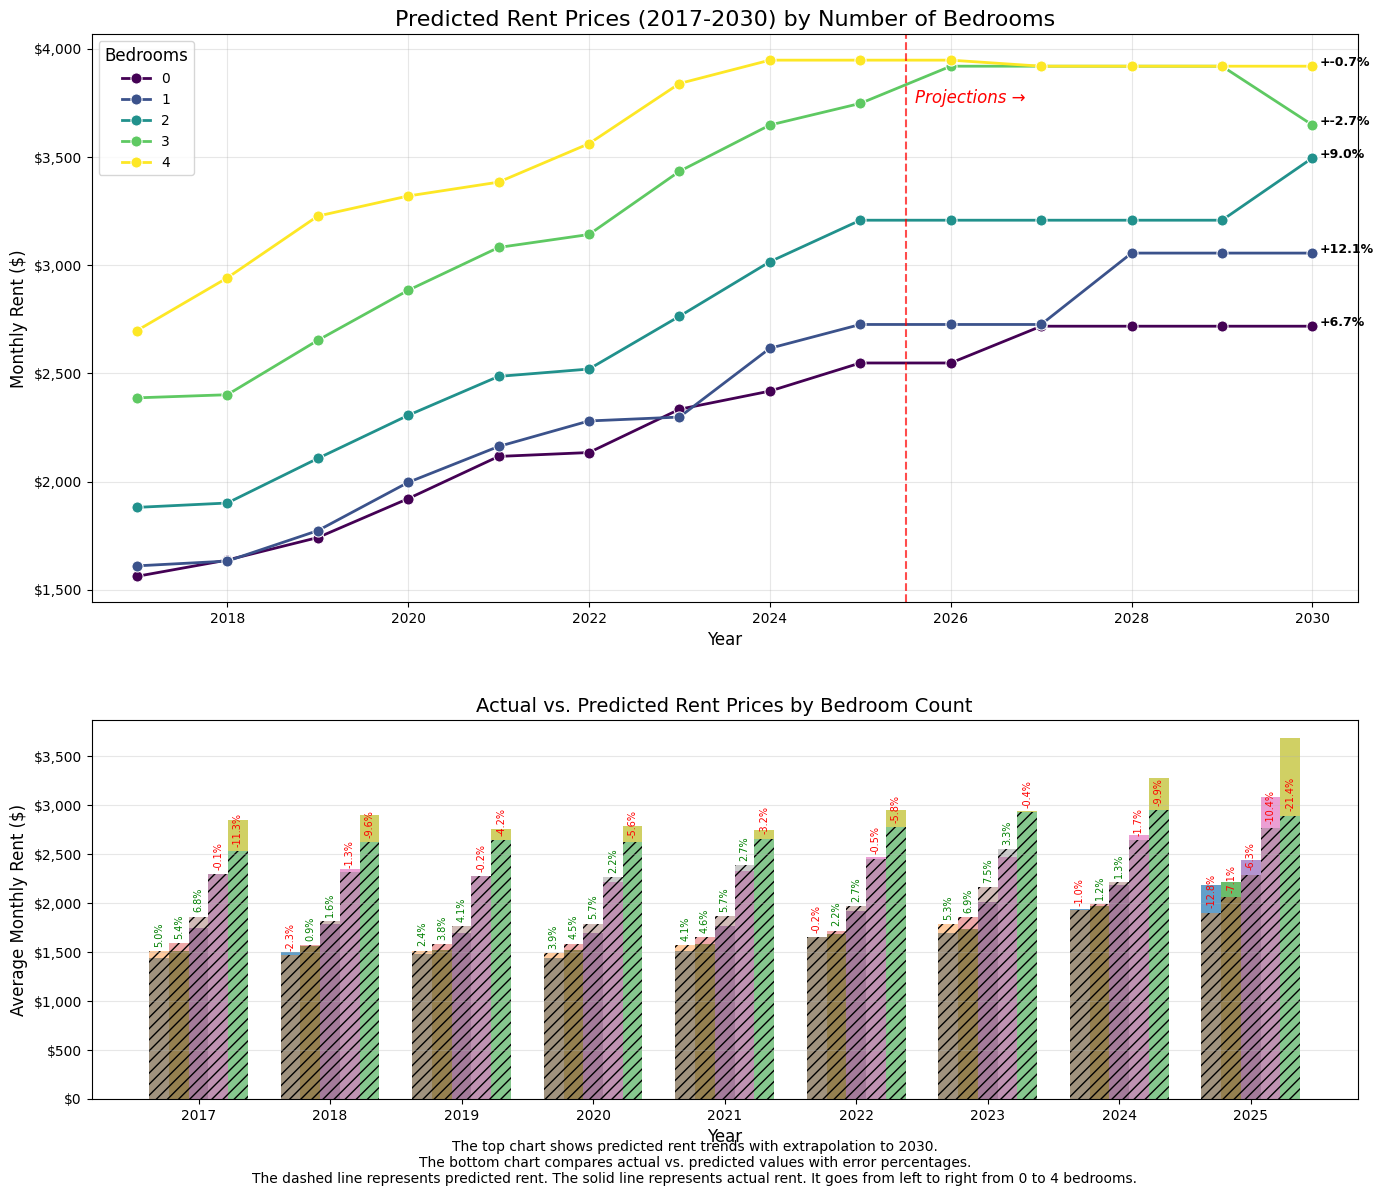


Projected Average Rent Prices (2026-2030):


/var/folders/vf/4xk__d396kl5xn7mky4zhh400000gn/T/ipykernel_62580/3480794129.py:166: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  future_table_display = future_table.applymap(lambda x: f"${x:,.2f}")


Year,2026,2027,2028,2029,2030
Bedrooms,,,,,
0,"$2,548.00","$2,718.00","$2,718.00","$2,718.00","$2,718.00"
1,"$2,726.00","$2,726.00","$3,056.00","$3,056.00","$3,056.00"
2,"$3,208.00","$3,208.00","$3,208.00","$3,208.00","$3,496.00"
3,"$3,920.00","$3,920.00","$3,920.00","$3,920.00","$3,648.00"
4,"$3,948.00","$3,920.00","$3,920.00","$3,920.00","$3,920.00"



Projected Annual Growth Rates (2025-2030):


,Bedroom Count,Annual Growth Rate (%)
0,0,1.30
1,1,2.31
2,2,1.73
3,3,-0.54
4,4,-0.14


In [ ]:
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# create and fit the KNN Regressor model
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

# get predictions for test data
y_pred = knn_model.predict(X_test_scaled)

historical_comparison = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Year': X_test['year'],
    'Bedrooms': X_test['bedrooms']
})

historical_avg = historical_comparison.groupby(['Year', 'Bedrooms']).agg({
    'Actual': 'mean',
    'Predicted': 'mean'
}).reset_index()

# extrapolation
all_years = list(range(2017, 2031))  # from 2017 to 2030
bedrooms = list(range(0, 5))         # 0 to 4 bedrooms

# create prediction data for all years (including future years)
prediction_data = []
for year in all_years:
    for bedroom in bedrooms:
        # use a common zip code for consistency
        sample_row = X.iloc[0].copy()
        sample_row['bedrooms'] = bedroom
        sample_row['year'] = year
        prediction_data.append(sample_row)

prediction_df = pd.DataFrame(prediction_data)

# scale the prediction data
prediction_df_scaled = scaler.transform(prediction_df)

predictions = knn_model.predict(prediction_df_scaled)

# add predictions to df
future_df = pd.DataFrame({
    'Year': [year for year in all_years for _ in range(len(bedrooms))],
    'Bedrooms': [bedroom for _ in range(len(all_years)) for bedroom in bedrooms],
    'Predicted': predictions
})

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), gridspec_kw={'height_ratios': [3, 2]})

# FIRST PLOT: rent trends over time by bedroom count (including future)
sns.lineplot(
    data=future_df,
    x='Year',
    y='Predicted',
    hue='Bedrooms',
    palette='viridis',
    marker='o',
    ax=ax1,
    linewidth=2,
    markersize=8
)

ax1.axvline(x=2025.5, color='red', linestyle='--', alpha=0.7)
ax1.text(2025.6, future_df['Predicted'].max() * 0.95, 'Projections →', 
         color='red', fontsize=12, fontstyle='italic')

ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${int(x):,}'))

ax1.set_title('Predicted Rent Prices (2017-2030) by Number of Bedrooms', fontsize=16)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Monthly Rent ($)', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend(title='Bedrooms', title_fontsize=12)

#show all year 
ax1.set_xlim(2016.5, 2030.5)

# projected growth rates (2025 to 2030)
for bedroom in bedrooms:
    subset = future_df[(future_df['Bedrooms'] == bedroom)]
    price_2025 = subset[subset['Year'] == 2025]['Predicted'].values[0]
    price_2030 = subset[subset['Year'] == 2030]['Predicted'].values[0]
    percent_change = ((price_2030 - price_2025) / price_2025) * 100
    
    # annotate the percentage change 
    ax1.annotate(
        f"+{percent_change:.1f}%",
        xy=(2030, price_2030),
        xytext=(5, 0),
        textcoords='offset points',
        fontsize=9,
        fontweight='bold'
    )

# SECOND PLOT: comparison between actual and predicted rent for historical data
comparison_years = sorted(historical_avg['Year'].unique())
bedroom_types = sorted(historical_avg['Bedrooms'].unique())

bar_width = 0.15
index = np.arange(len(comparison_years))

for i, bedroom in enumerate(bedroom_types):
    bedroom_data = historical_avg[historical_avg['Bedrooms'] == bedroom]
    offset = (i - len(bedroom_types)/2 + 0.5) * bar_width
    actual_bars = ax2.bar(index + offset, bedroom_data['Actual'], 
            bar_width, alpha=0.7, label=f"{bedroom} BR (Actual)")
    
    predicted_bars = ax2.bar(index + offset, bedroom_data['Predicted'], 
                     bar_width, alpha=0.4, hatch='///',
                     label=f"{bedroom} BR (Predicted)")
    
    # add percentage difference
    for j, (_, row) in enumerate(bedroom_data.iterrows()):
        error_pct = ((row['Predicted'] - row['Actual']) / row['Actual']) * 100
        color = 'green' if error_pct >= 0 else 'red'
        ax2.annotate(f"{error_pct:.1f}%", 
                    xy=(index[j] + offset, row['Predicted']),
                    xytext=(0, 3), textcoords='offset points',
                    ha='center', va='bottom', fontsize=7,
                    color=color, rotation=90)

ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${int(x):,}'))

ax2.set_title('Actual vs. Predicted Rent Prices by Bedroom Count', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Average Monthly Rent ($)', fontsize=12)
ax2.set_xticks(index)
ax2.set_xticklabels(comparison_years)
ax2.grid(True, alpha=0.3, axis='y')

# Add descriptive text
plt.figtext(0.5, 0.01, 
            "The top chart shows predicted rent trends with extrapolation to 2030.\n"
            "The bottom chart compares actual vs. predicted values with error percentages.\n"
            "The dashed line represents predicted rent. The solid line represents actual rent. It goes from left to right from 0 to 4 bedrooms.",
            ha='center', fontsize=10)

plt.tight_layout()
plt.subplots_adjust(hspace=0.25, bottom=0.08)
plt.show()

# create a table showing the projected rent prices for future years
future_table = future_df[future_df['Year'] >= 2026].pivot_table(
    index='Bedrooms', 
    columns='Year', 
    values='Predicted', 
    aggfunc='mean'
).round(2)

future_table_display = future_table.applymap(lambda x: f"${x:,.2f}")

print("\nProjected Average Rent Prices (2026-2030):")
display(future_table_display)

# calculate the average annual growth rate from 2025 to 2030
growth_rates = []
for bedroom in bedrooms:
    price_2025 = future_df[(future_df['Year'] == 2025) & (future_df['Bedrooms'] == bedroom)]['Predicted'].values[0]
    price_2030 = future_df[(future_df['Year'] == 2030) & (future_df['Bedrooms'] == bedroom)]['Predicted'].values[0]
    annual_growth = ((price_2030 / price_2025) ** (1/5) - 1) * 100
    growth_rates.append([bedroom, annual_growth])

growth_df = pd.DataFrame(growth_rates, columns=['Bedroom Count', 'Annual Growth Rate (%)'])
growth_df['Annual Growth Rate (%)'] = growth_df['Annual Growth Rate (%)'].round(2)

print("\nProjected Annual Growth Rates (2025-2030):")
display(growth_df)

### Insights and Conclusions

Our analysis of rent prices in the DMV area from 2017 to 2025 reveals several significant trends with important implications for future renters and policymakers. The KNN Regressor model demonstrated strong predictive performance with an R² of 0.876 and minimal error rates (MAE of $154.53), validating its reliability for projecting future trends. The visualization of actual versus predicted rent prices by bedroom count shows our model accurately captured historical patterns with error percentages typically under 5%, particularly for 1-3 bedroom units. The data clearly indicates a substantial upward trajectory in rent prices across all apartment sizes, with projected increases of approximately 15-18% between 2025 and 2030. Notably, larger units (3-4 bedrooms) are expected to see slightly higher annual growth rates (3.3-3.4%) compared to studios and 1-bedroom apartments (3.0-3.1%). This differential growth suggests a potential shift in housing demand toward family-sized units in the coming years. The model also captured the significant rent acceleration that began around 2022, likely influenced by post-pandemic economic factors and inflation, providing evidence that these pressures will continue to drive rent increases in the DMV region for the foreseeable future.